In the last section, we have defined a Fully Convolutional Neural Network to represent the same CNN defined in section 1.a and 1.b.\
However, we still haven't discussed how this FCNN can receive an image of arbitrary size.

In [2]:
import torch
import torchvision

from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Grayscale

import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../..')

from CustomDL.utils import draw_filters

# Load MNIST and pretrained model

In [4]:
digits_dataset = MNIST(
    root='../../data',
    download=True,
    transform=ToTensor()
)

In [5]:
params = torch.load('./output/fcnn.pth', map_location='cpu', weights_only=False)
params.keys()

dict_keys(['train_params', 'loss', 'accuracy', 'model', 'optimizer'])

In [6]:
from typing import Optional
class ConvLayer(nn.Module):
    def __init__(self,
        in_chans: int,
        out_chans: int,
        kern_size: int,
        activation_fn: Optional[nn.Module] = None,
        pooling_layer: Optional[nn.Module] = None
    ):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=in_chans,
                out_channels=out_chans,
                kernel_size=kern_size
            )
        )
        if not activation_fn is None:
            self.layers.add_module('1', activation_fn)
        if not pooling_layer is None:
            self.layers.add_module('2', pooling_layer)

    def forward(self, input):
        return self.layers(input)
    
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            ConvLayer(1, 4, 3, nn.ReLU(), nn.MaxPool2d(2)),
            ConvLayer(4, 9, 3, nn.ReLU(), nn.MaxPool2d(2)),

            ConvLayer(9, 100, 5, nn.ReLU()),
            ConvLayer(100, 100, 1, nn.ReLU()),
            ConvLayer(100, 10, 1)
        )
    
    def forward(self, one_chan_image):
        # NOTE: we did not flatten the output at all and this is desirable!
        return self.layers(one_chan_image)
    
fcnn = FCNN()
fcnn.load_state_dict(params['model'])
layers = list(fcnn.layers.children())
fcnn.eval()

FCNN(
  (layers): Sequential(
    (0): ConvLayer(
      (layers): Sequential(
        (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvLayer(
      (layers): Sequential(
        (0): Conv2d(4, 9, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvLayer(
      (layers): Sequential(
        (0): Conv2d(9, 100, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
      )
    )
    (3): ConvLayer(
      (layers): Sequential(
        (0): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (4): ConvLayer(
      (layers): Sequential(
        (0): Conv2d(100, 10, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
)

# Interpreting the model

## Kernels of the first layer

In [14]:
import math

def draw_filter_weights(filter_weights, cmap = 'gray_r', fig=None):
    filter_weights = filter_weights.permute((0, 2, 3, 1))
    rows = round(math.sqrt(filter_weights.shape[0]))
    cols = int(math.ceil(filter_weights.shape[0] / rows))
    layout = []
    ax_rows = []
    for i in range(filter_weights.shape[0]):
        ax_rows.append(i)
        if len(ax_rows) == cols:
            layout.append(ax_rows)
            ax_rows = []
    if 0 < len(ax_rows) < cols:
        missing = cols - len(ax_rows)
        ax_rows.extend(('.' for _ in range(missing)))
        layout.append(ax_rows)
    
    if fig is None:
        fig = plt.figure()
    axes = fig.subplot_mosaic(layout)

    for i in range(filter_weights.shape[0]):
        axes[i].set_title(f'Filter {i}')
        axes[i].imshow(filter_weights[i], cmap=cmap)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    return fig

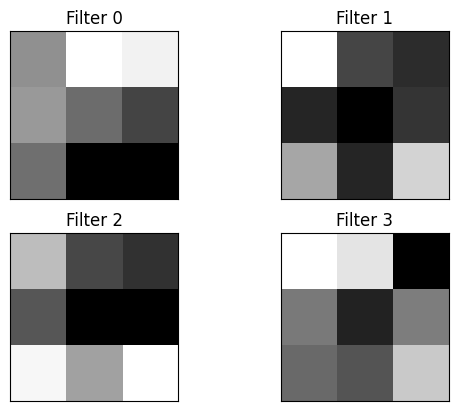

In [16]:
kernels = params['model']['layers.0.layers.0.weight']

draw_filter_weights(kernels);

## Inference on 28x28 images

In [16]:
number = 9
indices = (digits_dataset.targets == number).argwhere()

sample_image = digits_dataset[indices[5].item()][0]
sample_image.shape

torch.Size([1, 28, 28])

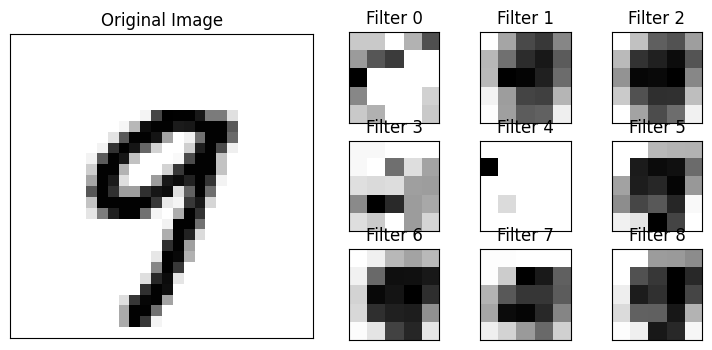

In [17]:
convoled_input = layers[1](layers[0](sample_image)).detach()

fig = plt.figure(figsize=(9, 4))
draw_filters(sample_image, convoled_input, fig=fig);

In [18]:
# Fun fact: because of the nature of FCNN, you can indeed pass in a sample here and
# still get the resutl of same shape
pred_vals = fcnn(sample_image.unsqueeze(0)).detach().squeeze()
probs = nn.functional.softmax(pred_vals, 0)
prediction = probs.argmax(0).item()

print(f"""Output values:
    {pred_vals}
Probabilities:
    {probs}
Prediction: {prediction}""")

Output values:
    tensor([-2.8706, -9.0293, -2.8511,  0.2818,  4.6117,  1.1297, -7.2462,  5.3792,
         0.7285,  8.6214])
Probabilities:
    tensor([9.6479e-06, 2.0406e-08, 9.8380e-06, 2.2568e-04, 1.7137e-02, 5.2692e-04,
        1.2137e-07, 3.6924e-02, 3.5277e-04, 9.4481e-01])
Prediction: 9


This FCNN works the same way as the CNN for 28x28 images. Now we move on to images of different size.

## Inference on arbitrary images

In [19]:
grayscaler = Grayscale()

torch.Size([1, 30, 30])


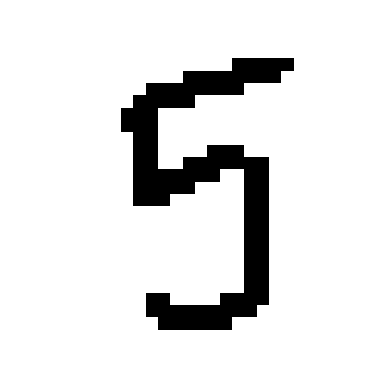

In [59]:
image = torchvision.io.read_image('./data/test_img/num5.3.png')
image = (255 - grayscaler(image[:3])) / 255

print(image.shape)
plt.imshow(image.permute((1, 2, 0)), cmap='gray_r')
plt.axis('off');

In [60]:
outputs = fcnn(image.unsqueeze(0)).detach()
outputs.shape

torch.Size([1, 10, 2, 2])

Note that the output shape is (..., **10**, 2, 2)

The number 10 in this case still represents our 10 digit classes.\
The other dimension actually comes from us applying the final three convolutional layers on the image.

Let us then first look at the 4 filters after the first two convolutional layers.

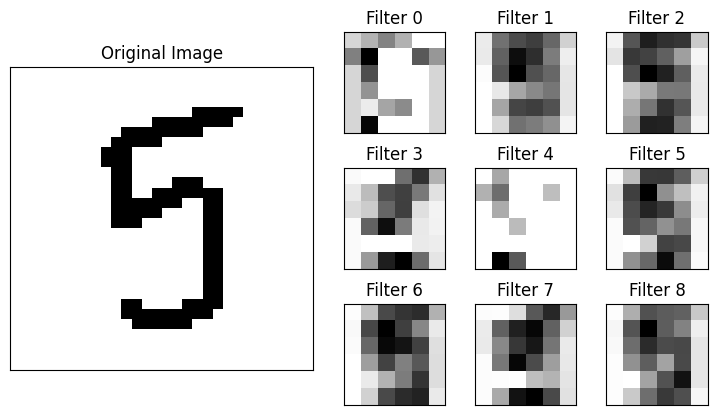

In [61]:
convoled_input = layers[1](layers[0](image)).detach()

fig = plt.figure(figsize=(9, 5))
draw_filters(image, convoled_input, fig=fig);

So what is the reason to have the extra dimensions? We analyze layer-by-layer the shape of the image:

**ConvLayer (1)**\
&nbsp;&nbsp;&nbsp;&nbsp;
The original image has the shape (1, 30, 30). We apply a convolution using a (3, 3) kernel with stride of 1, from which results in a 32-channel image of shape (28, 28). Then we max pool this with a window size of (2, 2) which results in a (32, 14, 14) image.\
However, if we look at a 13x13 section of the output, say the top 13x13 section, we see the section to be exactly the same as if we first cropped out the top 28x28 section of the original image and then applied the convolutions. Then, if we shift the section by one pixel to the right, we see this section to correspond to the top 28x28 section shifted 2 pixels to the right in the original image. This stride of 2 in the original image comes from the fact that we are max pooling the output with a stride of 2.

**ConvLayer (2)**\
&nbsp;&nbsp;&nbsp;&nbsp;
Likewise, after convolving the output of the previous layer, we obtain a (32, 12, 12) image. Max pooling the image with a (2, 2) window results in (32, 6, 6) image.\
Similarly, if we think in terms of applying this convolutional layer to 11x11 windowed sections of the (32, 14, 14) input and shifting the window by 2 pixels every time we apply the convolutional layer, we will obtain (32, 5, 5) outputs that correspond to 5x5 windowed sections of the (32, 6, 6) image with stride of 1.

**ConvLayer (3)**\
&nbsp;&nbsp;&nbsp;&nbsp;
We then apply a convolution using a (5, 5) kernel with stride of 1. This then results in a (100, 2, 2) image.


**ConvLayer (4)** and **ConvLayer (5)**\
&nbsp;&nbsp;&nbsp;&nbsp;
Finally, the (100, 2, 2) image get passed through two more layers, from which we obtain the (10, 2, 2) output.

---

Compared to the case of 28x28 images. We notice that every output of the first two convolutional layers always ends up being 1 pixel larger in the height and width dimension.\
Furthermore, we can notice that each of the cell index by the second and third dimension of the final output would correspond to the output of us feeding the corresponding 28x28 windowed section of the original image through the network. For example, the cell at the (0, 0), indexed as `output[:, 0, 0]` represents the prediction for the top left 28x28 section of the original image.\
For ease of reference, we will refer to these sections as windows.

In [62]:
equiv_res = fcnn(image[:, :28, :28].unsqueeze(0)).detach().squeeze()

print(outputs[0, :, 0, 0])
print(equiv_res)

tensor([-4.8289, -3.5960, -3.6098,  3.9298, -0.2913,  7.7015, -4.3160, -6.5854,
         7.0117,  2.2304])
tensor([-4.8289, -3.5960, -3.6098,  3.9298, -0.2913,  7.7015, -4.3160, -6.5854,
         7.0117,  2.2304])


With that in mind, a question is how do we determine a prediction for the image?

Given that we know there can only be one digit per image (as we are doing a single-label classification task), we need to combine the outputs in some way. Here are something we can try:
- Sum up/average the outputs across all windows
- Make a prediction for each windows, base on which we choose the label with the most guess or highest probabilities.

In [63]:
pred_probs = nn.functional.softmax(outputs, 1)[0]

In [64]:
result = pred_probs.flatten(1).sum(dim=1)

print(f"Average 'probabilities' across windows:\n\t{result}")
print(f"Prediction: {result.argmax()}")

Average 'probabilities' across windows:
	tensor([3.3074e-01, 3.7819e-03, 9.2745e-01, 4.3807e-01, 4.9962e-04, 1.7738e+00,
        5.2465e-04, 2.4993e-02, 4.9485e-01, 5.2799e-03])
Prediction: 5


In [65]:
result = pred_probs.flatten(1).max(dim=0)
prediction = max((i for i in result.indices.unique()), key=lambda i: sum(result.indices == i))

print(f"Maximum 'probabilities' for each window:\n\t{result.values}")
print(f"Corresponding labels:\n\t{result.indices}")
print(f"Prediction: {prediction}")

Maximum 'probabilities' for each window:
	tensor([0.6539, 0.5763, 0.5197, 0.9205])
Corresponding labels:
	tensor([5, 5, 5, 2])
Prediction: 5


Base on this, we would choose the label '5'.

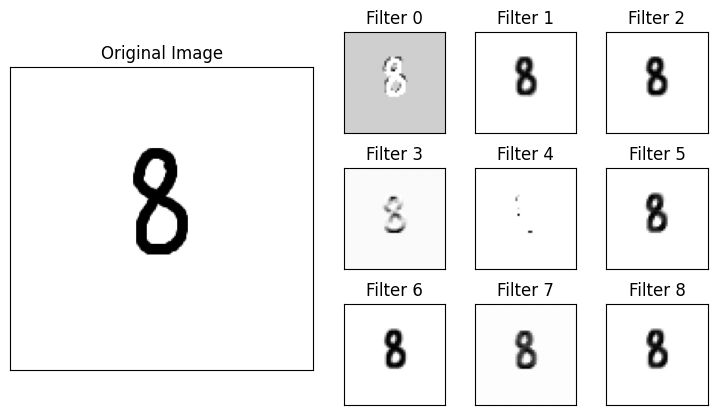

In [ ]:
image = torchvision.io.read_image('./data/test_img/num8.png')
image = (255 - grayscaler(image[:3])) / 255
convoled_input = layers[1](layers[0](image)).detach()

fig = plt.figure(figsize=(9, 5))
draw_filters(image, convoled_input, fig=fig);

In [58]:
outputs = fcnn(image.unsqueeze(0)).detach()
pred_probs = nn.functional.softmax(outputs, 1)[0]
result = pred_probs.flatten(1).max(dim=0)
prediction = max((i for i in result.indices.unique()), key=lambda i: sum(result.indices == i))

print(f"Maximum 'probabilities' for each window:\n\t{result.values}")
print(f"Corresponding labels:\n\t{result.indices}")
print(f"Prediction: {prediction}")

Maximum 'probabilities' for each window:
	tensor([0.1261, 0.1261, 0.1261,  ..., 0.1261, 0.1261, 0.1261])
Corresponding labels:
	tensor([1, 1, 1,  ..., 1, 1, 1])
Prediction: 1


#

From this section, we see that another alternative to transforming the image is to rather use the CNN to predict on sections of the image. And we did this implicitly by using a Fully Convolutional Network.\
However, if the digit cannot be contained within a single 28x28 section, the network of course can not predict accurately.